In [91]:
import pandas as pd
import numpy as np
import emoji
import string
from nltk.tokenize import TweetTokenizer
from collections import defaultdict
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from collections import Counter
from math import log
from pprint import pformat
from scipy.sparse.linalg import svds
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline

In [92]:
# load preformatted and semi-preprocessed dataset
tweets_and_labels_RAW = pd.read_csv('emoji_datasets/all_data.csv', header=None, encoding='utf-8')

In [93]:
# separates emojis from eachother and other words
def separate_emojis(example):
    result = []
    ptr = 0
    for i,c in enumerate(example):
        if c in emoji.UNICODE_EMOJI:
            split = example[ptr:i]
            if split != '':
                result.append(split)
                result.append(c)
            else:
                result.append(c)
            ptr = i+1
    return result

# tokenize and separate emojis
def preprocess(data):
    labels = list(data[:,0])
    tweets = list(data[:,1])
    result = []
    tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    for i,twt in enumerate(tweets):
        clean_tokens = []
        tokens = tweet_tokenizer.tokenize(twt)
        for j,tk in enumerate(tokens):
            tk = tk.lower()
            sep = separate_emojis(tk)
            if sep != []:
                clean_tokens = clean_tokens + sep
            else:
                clean_tokens.append(tk)
        result.append((labels[i], clean_tokens))
    return result

# creates a dictionary of emojis and their counts
def find_all_emojis(data):
    emoji_dict = defaultdict(int)
    for twt in data:
        for word in twt[1]:
            if word in emoji.UNICODE_EMOJI:
                emoji_dict[word] += 1
    return emoji_dict

# creates a term-context matrix (dictionary of dictionaries)
def term_context_matrix(targets, data):
    tc_matrix = defaultdict(lambda: defaultdict(lambda: 0))
    for twt in data:
        for w1 in targets:
            if w1 in twt[1]:
                for w2 in twt[1]:
                    tc_matrix[w1][w2]+=1
    return tc_matrix

# utility method for making a sparse term-context matrix
def vocab_map(dd):
    vocab = {}
    vocab_id = 0
    for k,v in dd.items():
        for k2,v2 in v.items():
            if k2 not in vocab.keys():
                vocab[k2] = vocab_id
                vocab_id += 1
    return vocab

# utility method for making a sparse term-context matrix
def term_to_int_dd(dd):
    num_rows = len(dd.keys())
    data = defaultdict(int)
    vocab_dict = vocab_map(dd)
    for i,r in enumerate(dd.keys()):
        for j,c in enumerate(dd[r].keys()):
            data[i,vocab_dict[c]] = dd[r][c]
            
    return data

# creates a sparse term-context matrix
def term_to_sparse(dd):
    dd_int = term_to_int_dd(dd)
    vs = [v for (i,j), v in dd_int.items()]
    ii = [i for (i,j), v in dd_int.items()]
    jj = [j for (i,j), v in dd_int.items()]
    matrix = coo_matrix((vs, (ii, jj)))
    return matrix



In [94]:
tweets_and_labels = preprocess(tweets_and_labels_RAW.values) # all tweets and labels 
emoji_counts = find_all_emojis(tweets_and_labels) # all emoji counts
emoji_targets = list(emoji_counts.keys()) # all emoji targets

In [95]:

term_matrix = term_context_matrix(emoji_targets, tweets_and_labels)


In [96]:
# sparse term-context matrix (not used currently)
emoji_coo_matrix = term_to_sparse(term_matrix)


In [97]:
# counts all target emojis, context words, and emoji-context pairs
def unigram_bigram_counts(targets, tweets, term_matrix):
    target_counter = Counter()
    vocab_counter = Counter()
    bigram_counter = Counter()
    for twt in tweets:
        for word in twt[1]:
            if word in targets:
                target_counter[word] += 1
            vocab_counter[word] += 1
    
    for emoji in term_matrix.keys():
        for word in term_matrix[emoji].keys():
            bigram_counter[(emoji,word)] = term_matrix[emoji][word]
            
    return target_counter, vocab_counter, bigram_counter

# utility method for creating pmi matrix
def unigram_index_maps(counter):
    val_to_index, index_to_val = {}, {}
    for i, x in enumerate(counter.keys()):
        val_to_index[x] = i
        index_to_val[i] = x
    return val_to_index, index_to_val


def prune_counts(tc_RAW, vc_RAW, bc_RAW):
    '''
        Remove target and vocab words which occur less than 5 times
        Replace with UNK word
    '''
    tc = tc_RAW.copy()
    vc = vc_RAW.copy()
    bc = bc_RAW.copy()
    
    min_occurence = 5
    unk = 'UNK'
    for wt in list(tc.keys()):
        if tc[wt] < min_occurence:
            count = tc[wt]
            del tc[wt]
            tc[unk] += count
    for wv in list(vc.keys()):
        if vc[wv] < min_occurence:
            count = vc[wv]
            del vc[wv]
            vc[unk] += count
    for x,y in list(bc.keys()):
        if x not in tc and y not in vc:
            count = bc[(x, y)]
            del bc[(x, y)]
            bc[(unk,unk)] += count
        elif x not in tc:
            count = bc[(x, y)]
            del bc[(x, y)]
            bc[(unk,y)] += count
        elif y not in vc:
            count = bc[(x, y)]
            del bc[(x, y)]
            bc[(x,unk)] += count
            
    return tc, vc, bc

# smooth context words with alpha = 0.75
def context_distribution_smoothing(context, alpha = 0.75):
    for c in context.keys():
        context[c] = context[c]**alpha
    return context
        
    
def pmi_matrix(params):
    '''
        Creates a PMI sparse matrix 
        
        tc   : target_counts
        vc   : vocab_counts
        bc   : bigram_counts
        
        tcs  : target_count_sum
        vcs  : vocab_count_sum
        bcs  : bigram_count_sum
        
        tv2i : target_v2i  (target value to index)
        ti2v : target_i2v  (index to target value)
        vv2i : vocab_v2i   (vocab value to index)
        vi2v : vocab_i2v   (index to vocab value)
    '''
    
    tc   = params['tc']
    vc   = params['vc']
    bc   = params['bc']
    tcs  = params['tcs']
    vcs  = params['vcs']
    bcs  = params['bcs']
    tv2i = params['tv2i']
    ti2v = params['ti2v']
    vv2i = params['vv2i']
    vi2v = params['vi2v']
    
    pmi_samples = Counter()
    data = []
    rows = []
    cols = []
    for (x, y), n in bc.items():
        rows.append(tv2i[x]) # target index
        cols.append(vv2i[y]) # context index
        data.append(log((n / bcs) / (((tc[x] / tcs)) * (vc[y] / vcs))))
        pmi_samples[(x, y)] = data[-1]
        
    pmi_matrix = csc_matrix((data, (rows, cols)))
    
    return pmi_matrix, pmi_samples 
        


In [98]:

target_counts_RAW, vocab_counts_RAW, bigram_counts_RAW = unigram_bigram_counts(emoji_targets, tweets_and_labels, term_matrix)


In [99]:
# original unigram and bigram counts
target_counts, vocab_counts, bigram_counts = prune_counts(target_counts_RAW, vocab_counts_RAW, bigram_counts_RAW)

# smoothed context counts
vocab_counts = context_distribution_smoothing(vocab_counts)

In [100]:
# unigram and bigram sums
target_count_sum = sum(target_counts.values())
vocab_count_sum = sum(vocab_counts.values())
bigram_count_sum = sum(bigram_counts.values())


In [101]:
# value to index, index to value maps for pmi matrix and svd
target_v2i, target_i2v = unigram_index_maps(target_counts)
vocab_v2i, vocab_i2v = unigram_index_maps(vocab_counts)


In [102]:
# parameters for pmi matrix
pmi_params = {
    'tc'    : target_counts,
    'vc'    : vocab_counts,
    'bc'    : bigram_counts,
    'tcs'   : target_count_sum,
    'vcs'   : vocab_count_sum,
    'bcs'   : bigram_count_sum,
    'tv2i'  : target_v2i,
    'ti2v'  : target_i2v,
    'vv2i'  : vocab_v2i,
    'vi2v'  : vocab_i2v
}


In [103]:
# pmi matrix
pmi_matrix, pmi_samples = pmi_matrix(pmi_params)

In [ ]:
'''
    Example output:
    
    (('🎅','🎄'), 6.1111635797210235)
    
    or
    
    (('😍', '💔'), -2.30884562077705)
    
'''
print()
print(pmi_matrix.shape)
print()
print(pformat(pmi_samples.most_common()[:10]))

In [105]:
# Singular Value Decomposition (SVD)
def factorize_pmi_matrix(pmi, t_i2v, t_v2i):
    '''
        pmi_matrix : the PMI matrix
        i2v : target_v2i
        v2i : target_i2v
        
        Computes U, sigma, Vh using SVD
        Computes W_svd = U dot sigma^0.5
        Normalizes W_svd:
            rendering cosine similarity equivalent to dot product
            
    '''
    # Factorize the PMI matrix
    # k : number of singular values and vectors to compute
    U, sigma, Vh = svds(pmi, k=150)
    sigma_p = sigma**0.5
    
    # compute W_svd
    W_svd = U*sigma_p
    
    # Normalize the vectors to enable computing cosine similarity    
    norms = np.sqrt(np.sum(np.square(W_svd), axis=1, keepdims=True))
    W_svd_n = U / np.maximum(norms, 1e-7)
    
    sample_emojis = list(t_v2i.keys())
    k = 5
    for x in sample_emojis:
        '''
            Cosine similarity with target emoji x against all others
        '''
        dd = np.dot(W_svd_n, W_svd_n[t_v2i[x]])
        
        # Get best cosine similarity 
        result = '\nBest: '
        for i in np.argsort(dd)[-(k+1):]:
            result += '(%s, %f) ' % (t_i2v[i], dd[i])
            
        # Get worst cosine simillarity 
        result += '\nWorst: '
        for i in np.argsort(dd)[:k]:
            result += '(%s, %f) ' % (t_i2v[i], dd[i])
        print('%s, %d\n %s' % (x, target_counts[x], result))
        print()
        print('-' * 20)
        print()
    
    

In [ ]:
'''
    Example output:
    
    🎅, 7
        Best: (🎃, 0.005975) (🏈, 0.008036) (⛄, 0.008878) (🎁, 0.014411) (🎄, 0.023650) (🎅, 0.026799) 
        Worst: (❄, -0.004854) (🍁, -0.003870) (👻, -0.003339) (🔮, -0.003046) (🍰, -0.002804) 

'''
factorize_pmi_matrix(pmi_matrix, target_i2v, target_v2i)

In [18]:
tsne = TSNE(n_components=2, random_state=0)
TCM_2d = tsne.fit_transform(pmi_matrix.toarray())
emoji_targets_pruned = list(target_counts.keys())

In [19]:
PMI_points = pd.DataFrame(
    [
        (emoji, coords[0], coords[1])
        for emoji, coords in [
            (emoji, TCM_2d[emoji_targets_pruned.index(emoji)])
            for emoji in emoji_targets_pruned
        ]
    ],
    columns=["emoji", "x", "y"]
)

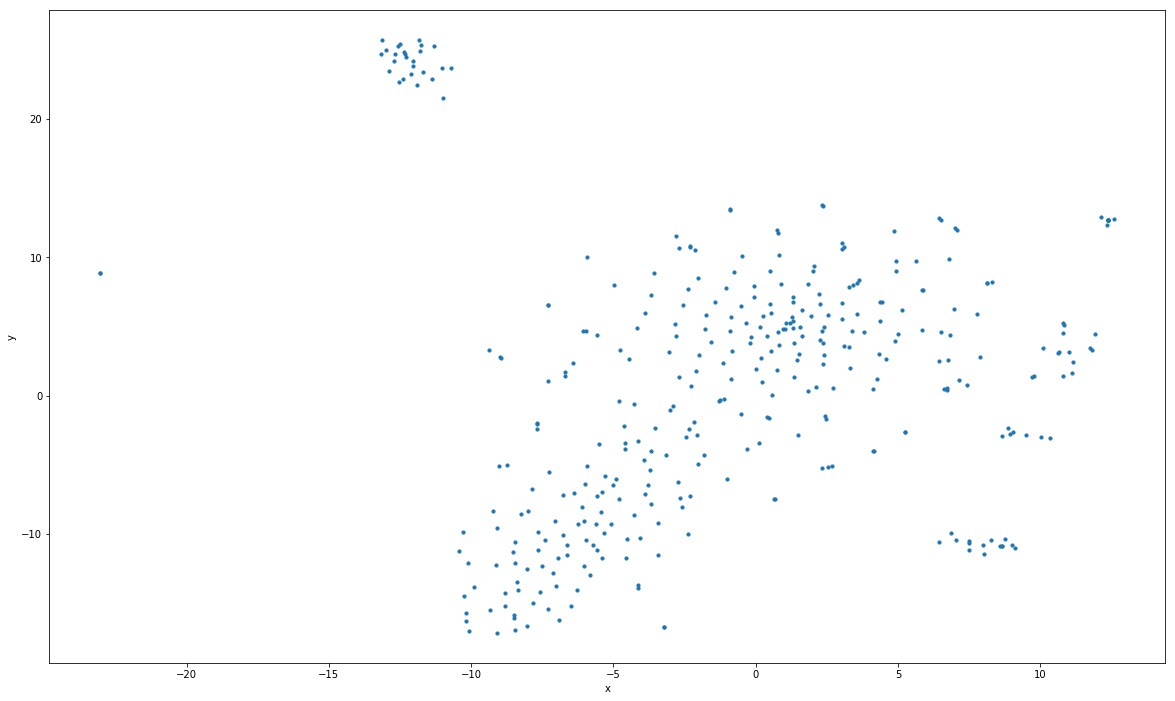

In [20]:
PMI_points.plot.scatter('x','y',s=10, figsize=(20,12))

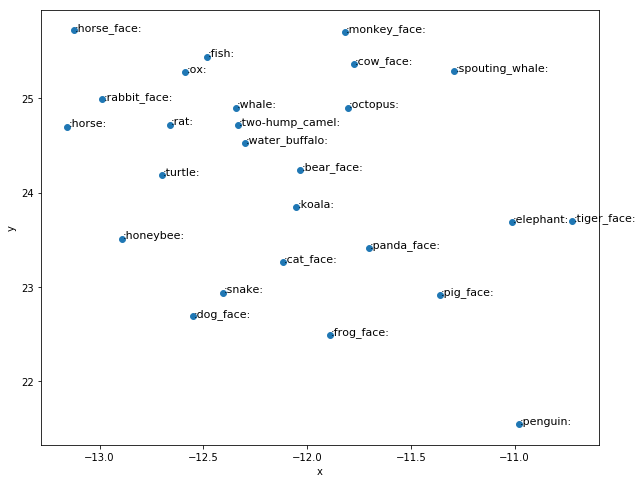

In [25]:
def plot_region(x_bounds, y_bounds):
    slice = PMI_points[
        (x_bounds[0] <= PMI_points.x) &
        (PMI_points.x <= x_bounds[1]) & 
        (y_bounds[0] <= PMI_points.y) &
        (PMI_points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, emoji.UNICODE_EMOJI[point.emoji], fontsize=11)
plot_region(x_bounds=(-15,-10), y_bounds=(20,30))